<a href="https://colab.research.google.com/github/RaihanAminRana/EEE_312_DeepFake/blob/CollabNotebooks/Copy_of_Bhasa_Bhrom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle
from google.colab import drive
drive.mount('/content/drive')
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/ColabNotebooks/KaggleAPICredentials/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d raihanaminrana/uniform-dataset-1
! unzip uniform-dataset-1


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 89% 2.00M/2.23M [00:01<00:00, 2.22MB/s]
100% 2.23M/2.23M [00:01<00:00, 2.12MB/s]
Archive:  uniform-dataset-1.zip
  inflating: Extracted_Sentences_1.csv  


In [ ]:
# importing the packages
import pandas as pd
import numpy as np

import os
from os import listdir
from os.path import isfile, join
from collections import namedtuple

import time
import re
from sklearn.model_selection import train_test_split


import unicodedata








#Importing libraries
import tensorflow as tf
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
# Parameters for our model
INPUT_COLUMN = 'input'
TARGET_COLUMN = 'target'
TARGET_FOR_INPUT = 'target_for_input'
NUM_SAMPLES = 50000 #40000
MAX_VOCAB_SIZE = 200
EMBEDDING_DIM = 128
HIDDEN_DIM = 512 #1024 512

BATCH_SIZE = 64  # Batch size for training.
EPOCHS = 4 # Number of epochs to train for.

ATTENTION_FUNC='concat'

In [ ]:
input_file = "/content/Extracted_Sentences_1.csv"
data = pd.read_csv(input_file)
print(data["Sentences"])
raw_sentences = data['Sentences'].astype(str)

0                                               কর তা হলে।
1                                               মরণ আর কি?
2                                               বলো কী গো?
3                                               —সে কী রে?
4                                               ঠিক কি না!
                               ...                        
46472    উদ্বোধনী অনুষ্ঠানে আরো উপস্থিত ছিলেন বাংলাদেশে...
46473    অনলাইন সংরক্ষণ // পর্যটন কেন্দ্র কুয়াকাটা সৈকত...
46474    সাম্প্রতিক একটি সমীক্ষা জানাচ্ছে, প্রতিদ্বন্দ্...
46475    সমাজতান্ত্রিক চেতনায় ঋৃদ্ধ গণসংগীত, যা বুর্জো...
46476    অবশেষে দেশের বাকি ১৪টি পূর্ণাঙ্গ ও পুরাতন নদীব...
Name: Sentences, Length: 46477, dtype: object


In [ ]:
char = unicodedata.normalize('NFKD',str(['ঁ', 'ং', 'ঃ', 'অ', 'আ', 'ই', 'ঈ', 'উ', 'ঊ', 'ঋ', 'এ', 'ঐ', 'ও', 'ঔ', 'ক', 'খ', 'গ', 'ঘ', 'ঙ', 'চ', 'ছ', 'জ', 'ঝ', 'ঞ', 'ট', 'ঠ', 'ড', 'ঢ', 'ণ', 'ত', 'থ', 'দ', 'ধ', 'ন', 'প', 'ফ', 'ব', 'ভ', 'ম', 'য', 'র', 'ল', 'শ', 'ষ', 'স', 'হ', '়', 'া', 'ি', 'ী', 'ু', 'ূ', 'ৃ', 'ে', 'ৈ', 'ো', 'ৌ', '্', 'ৎ', '০', '১', '২', '৩', '৪', '৫', '৬', '৭', '৮', '৯',' ','৷', '!','?','%', "'",'"', '(', ')', '*', '+', ',', '-', '.', '/', ';',  '=', '>', '?', '~', '…']))
char = char[:]

In [ ]:
def clean_sentence(sentence):
    sentence = unicodedata.normalize('NFKD', sentence)

    sentence = re.sub(r'-|-|-|-' ,'-', sentence)
    sentence = re.sub(r'“|"|“', '"', sentence)
    sentence = re.sub(r'।|।','৷', sentence)
    sentence = re.sub(r' া|ा', 'ा', sentence)
    sentence = re.sub(r'‘|’', "'", sentence)
    sentence = re.sub(r':','ঃ', sentence)
    sentence = re.sub(r'[a-zA-Z0-9]+','',sentence) ###english words 
    sentence  = re.sub(r' +',' ', sentence)   ###extra spaces
    sentence = sentence.strip()     ###leading and triling spce
    sentence = ''.join(c for c in sentence if c in char)
    return unicodedata.normalize('NFKD', sentence)

In [ ]:
sentences = []
# Find the length of each sentence
lengths = []
for sentence in raw_sentences:
    if (len(sentence.split()) >=4) or (len(sentence.split()) <= 500):
        extracted = " ".join(sentence.split())
        extracted = clean_sentence(extracted)
        sentences.append(extracted)
        lengths.append(len(extracted.split()))
lengths = pd.DataFrame(lengths, columns=["counts"])
lengths.describe()

,counts
count,46477.000000
mean,10.316070
std,6.856739
min,2.000000
25%,6.000000
50%,8.000000
75%,13.000000
max,40.000000


Loading the data

In [ ]:
# Create a dictionary to convert the vocabulary (characters) to integers
vocab_to_int = {}
count = 1

for character in list(" ".join(sentences)):
    if character not in vocab_to_int:
        vocab_to_int[character] = count
        count += 1

# Add special tokens to vocab_to_int
codes = ['<PAD>','<EOS>','<GO>']
for code in codes:
    vocab_to_int[code] = count
    count += 1

In [ ]:
# Check the size of vocabulary and all of the values
vocab_size = len(vocab_to_int)
print("The vocabulary contains {} characters.".format(vocab_size))
print(sorted(vocab_to_int))

The vocabulary contains 92 characters.
[' ', '!', '"', '%', "'", '(', ')', '*', '+', ',', '-', '.', '/', ';', '<EOS>', '<GO>', '<PAD>', '=', '>', '?', '[', ']', '~', 'ঁ', 'ং', 'ঃ', 'অ', 'আ', 'ই', 'ঈ', 'উ', 'ঊ', 'ঋ', 'এ', 'ঐ', 'ও', 'ঔ', 'ক', 'খ', 'গ', 'ঘ', 'ঙ', 'চ', 'ছ', 'জ', 'ঝ', 'ঞ', 'ট', 'ঠ', 'ড', 'ঢ', 'ণ', 'ত', 'থ', 'দ', 'ধ', 'ন', 'প', 'ফ', 'ব', 'ভ', 'ম', 'য', 'র', 'ল', 'শ', 'ষ', 'স', 'হ', '়', 'া', 'ি', 'ী', 'ু', 'ূ', 'ৃ', 'ে', 'ৈ', '্', 'ৎ', 'ৗ', '০', '১', '২', '৩', '৪', '৫', '৬', '৭', '৮', '৯', '৷']


In [ ]:
# Create another dictionary to convert integers to their respective characters
int_to_vocab = {}
for character, value in vocab_to_int.items():
    int_to_vocab[value] = character

In [ ]:
# Convert sentences to integers
int_sentences = []

for sentence in sentences:
    int_sentence = []
    for character in list(sentence):
        int_sentence.append(vocab_to_int[character])
    int_sentences.append(int_sentence)
    
print(sentences[2])
print(int_sentences[2])

বলো কী গো?
[15, 7, 8, 5, 3, 1, 16, 3, 17, 8, 5, 14]


In [ ]:
# Find the length of each sentence
lengths = []
for sentence in int_sentences:
    lengths.append(len(sentence))
lengths = pd.DataFrame(lengths, columns=["counts"])
lengths.describe()

,counts
count,46477.000000
mean,65.232201
std,46.637943
min,9.000000
25%,33.000000
50%,51.000000
75%,81.000000
max,331.000000


In [ ]:
# Limit the data we will use to train our model
max_length = 200
min_length = 10

good_sentences = []

for sentence in int_sentences:
    if len(sentence) <= max_length and len(sentence) >= min_length:
        good_sentences.append(sentence)

print("Total number of {} sentences to train and test our model.".format(len(good_sentences)))

Total number of 45348 sentences to train and test our model.


In [ ]:
# Split the data into training and testing sentences
training, testing = train_test_split(good_sentences, test_size = 0.2, random_state = 2)

print("Number of training sentences:", len(training))
print("Number of testing sentences:", len(testing))
print(testing[0])

Number of training sentences: 36278
Number of testing sentences: 9070
[31, 15, 8, 34, 5, 2, 3, 32, 40, 29, 5, 35, 29, 30, 40, 29, 5, 2, 20, 8, 18, 51, 3, 17, 40, 2, 8, 34, 5, 2, 3, 12, 20, 40, 37, 5, 2, 18, 40, 34, 40, 29, 5, 20, 40, 37, 13, 58, 51, 3, 25, 13, 18, 57, 23, 7, 3, 35, 29, 30, 5, 2, 40, 7, 40, 37, 31, 66, 3, 24, 3, 18, 40, 7, 8, 5, 17, 5, 20, 1, 8, 3, 18, 5, 10, 20, 8, 3, 2, 8, 33, 8, 3, 24, 18, 15, 3, 1, 2, 40, 10, 18, 54, 22, 13, 3, 25, 5, 7, 20, 3, 1, 2, 5, 3, 6, 22, 40, 47, 8, 3, 18, 8, 33, 5, 20, 8, 9]


In [ ]:
# Sort the sentences by length to reduce padding, which will allow the model to train faster
training_sorted = []
testing_sorted = []

for i in range(min_length, max_length+1):
    for sentence in training:
        if len(sentence) == i:
            training_sorted.append(sentence)
    for sentence in testing:
        if len(sentence) == i:
            testing_sorted.append(sentence)

In [ ]:
# Check to ensure the sentences have been selected and sorted correctly
for i in range(5):
    print(training_sorted[i], len(training_sorted[i]))

[1, 13, 3, 6, 15, 8, 3, 20, 5, 14] 10
[18, 8, 3, 1, 16, 3, 17, 5, 20, 9] 10
[24, 3, 1, 16, 3, 36, 5, 43, 5, 21] 10
[1, 13, 3, 24, 3, 26, 37, 30, 13, 14] 10
[24, 3, 29, 8, 3, 20, 5, 2, 16, 21] 10


In [ ]:
# Method to Relocate, remove, or add characters to create spelling mistakes
letters = [' ', '!', "'", '(', ')', ',', '-', '.', '/', ';', '?', '[', ']', '~', 'ঁ', 'ং', 'ঃ', 'অ', 'আ', 'ই', 'ঈ', 'উ', 'ঊ', 'ঋ', 'এ', 'ঐ', 'ও', 'ঔ', 'ক', 'খ', 'গ', 'ঘ', 'ঙ', 'চ', 'ছ', 'জ', 'ঝ', 'ঞ', 'ট', 'ঠ', 'ড', 'ঢ', 'ণ', 'ত', 'থ', 'দ', 'ধ', 'ন', 'প', 'ফ', 'ব', 'ভ', 'ম', 'য', 'র', 'ল', 'শ', 'ষ', 'স', 'হ', '়', 'া', 'ি', 'ী', 'ু', 'ূ', 'ৃ', 'ে', 'ৈ', '্', 'ৎ', 'ৗ', '৷']
def noise_maker(sentence, threshold):   
    
    noisy_sentence = []
    i = 0
    while i < len(sentence):
        random = np.random.uniform(0,1,1)
        # Most characters will be correct since the threshold value is high
        if random < threshold:
            noisy_sentence.append(sentence[i])
        else:
            new_random = np.random.uniform(0,1,1)
            # ~33% chance characters will swap locations
            if new_random > 0.67:
                if i == (len(sentence) - 1):
                    # If last character in sentence, it will not be typed
                    continue
                else:
                    # if any other character, swap order with following character
                    noisy_sentence.append(sentence[i+1])
                    noisy_sentence.append(sentence[i])
                    i += 1
            #~33% chance an extra lower case letter will be added to the sentence
            elif new_random < 0.33:
                random_letter = np.random.choice(letters, 1)[0]
                #print(random_letter[0])
                noisy_sentence.append(vocab_to_int[random_letter])
                noisy_sentence.append(sentence[i])
            # ~33% chance a character will not be typed
            else:
                pass     
        i += 1
    return noisy_sentence

In [ ]:
threshold = 0.9
input_sequence = []
target_sequence = []
target_output_sequence = []
for sentence in training:
    input_sequence.append(noise_maker(sentence, threshold))
    target_sequence.append(sentence + [ vocab_to_int['<EOS>'] ])
    target_output_sequence.append([ vocab_to_int['<GO>'] ]+sentence)
    
print(input_sequence[0])
print(target_sequence[0])
print(target_output_sequence[0])

[18, 8, 39, 3, 53, 8, 7, 8, 2, 3, 15, 13, 53, 18, 40, 57, 8, 5, 2, 11, 8, 3, 26, 33, 10, 3, 20, 3, 18, 5, 29, 30, 5, 2, 3, 6, 12, 10, 8, 49, 3, 53, 8, 33, 23, 3, 21, 20, 5, 10, 36, 8, 3, 24, 1, 3, 29, 23, 15, 1, 9]
[18, 8, 39, 3, 53, 8, 7, 8, 2, 3, 15, 13, 18, 40, 57, 8, 5, 2, 11, 8, 3, 26, 33, 10, 3, 6, 20, 3, 18, 5, 29, 30, 5, 2, 3, 12, 6, 10, 8, 49, 3, 53, 8, 33, 3, 20, 5, 10, 8, 3, 24, 1, 3, 29, 23, 15, 1, 9, 91]
[92, 18, 8, 39, 3, 53, 8, 7, 8, 2, 3, 15, 13, 18, 40, 57, 8, 5, 2, 11, 8, 3, 26, 33, 10, 3, 6, 20, 3, 18, 5, 29, 30, 5, 2, 3, 12, 6, 10, 8, 49, 3, 53, 8, 33, 3, 20, 5, 10, 8, 3, 24, 1, 3, 29, 23, 15, 1, 9]


Padding

In [ ]:
input_max_len = max(len(s) for s in input_sequence)
target_max_len = max(len(s) for s in target_sequence)



# pad the input sequences
encoder_inputs = pad_sequences(input_sequence, maxlen=input_max_len, padding='post')
print("encoder_inputs.shape:", encoder_inputs.shape)
print("encoder_inputs[0]:", encoder_inputs[0])
# pad the decoder input sequences
decoder_inputs = pad_sequences( target_output_sequence, maxlen=target_max_len, padding='post')
print("decoder_inputs[0]:", decoder_inputs[0])
print("decoder_inputs.shape:", decoder_inputs.shape)
# pad the target output sequences
decoder_targets = pad_sequences(target_sequence, maxlen=target_max_len, padding='post')

encoder_inputs.shape: (36278, 208)
encoder_inputs[0]: [18  8 39  3 53  8  7  8  2  3 15 13 53 18 40 57  8  5  2 11  8  3 26 33
 10  3 20  3 18  5 29 30  5  2  3  6 12 10  8 49  3 53  8 33 23  3 21 20
  5 10 36  8  3 24  1  3 29 23 15  1  9  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
decoder_inputs[0]: [92 18  8 39  3 53  8  7  8  2  3 15 13 18 40 57  8  5  2 11  8  3 26 33
 10  3  6 20  3 18  5 29 30  5  2  3 12  6 10  8 49  3 53  8 33  3 20  5
 10  8  3 24  1  3 29 23 15  1  9  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 

create a dataset

In [ ]:
# Define a dataset 
dataset = tf.data.Dataset.from_tensor_slices(
    (encoder_inputs, decoder_inputs, decoder_targets))
dataset = dataset.shuffle(len(training_sorted)).batch(
    BATCH_SIZE, drop_remainder=True)

Model Building

In [ ]:
#Encoder

class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(Encoder, self).__init__()
        self.hidden_dim = hidden_dim
        # Define the embedding layer
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        # Define the RNN layer, LSTM
        self.lstm = tf.keras.layers.LSTM(
            hidden_dim, return_sequences=True, return_state=True)

    def call(self, input_sequence, states):
        # Embed the input
        embed = self.embedding(input_sequence)
        # Call the LSTM unit
        output, state_h, state_c = self.lstm(embed, initial_state=states)

        return output, state_h, state_c

    def init_states(self, batch_size):
        # Return a all 0s initial states
        return (tf.zeros([batch_size, self.hidden_dim]),
                tf.zeros([batch_size, self.hidden_dim]))

In [ ]:
#Attention Layer
class LuongAttention(tf.keras.Model):
    def __init__(self, rnn_size, attention_func):
        super(LuongAttention, self).__init__()
        self.attention_func = attention_func

        if attention_func not in ['dot', 'general', 'concat']:
            raise ValueError(
                'Attention score must be either dot, general or concat.')

        if attention_func == 'general':
            # General score function
            self.wa = tf.keras.layers.Dense(rnn_size)
        elif attention_func == 'concat':
            # Concat score function
            self.wa = tf.keras.layers.Dense(rnn_size, activation='tanh')
            self.va = tf.keras.layers.Dense(1)

    def call(self, decoder_output, encoder_output):
        if self.attention_func == 'dot':
            # Dot score function: decoder_output (dot) encoder_output
            # decoder_output has shape: (batch_size, 1, rnn_size)
            # encoder_output has shape: (batch_size, max_len, rnn_size)
            # => score has shape: (batch_size, 1, max_len)
            score = tf.matmul(decoder_output, encoder_output, transpose_b=True) # (batch_size, 1, max_len)
        elif self.attention_func == 'general':
            # General score function: decoder_output (dot) (Wa (dot) encoder_output)
            # decoder_output has shape: (batch_size, 1, rnn_size)
            # encoder_output has shape: (batch_size, max_len, rnn_size)
            # => score has shape: (batch_size, 1, max_len)
            score = tf.matmul(decoder_output, self.wa(
                encoder_output), transpose_b=True) #(batch_size, 1, max_len)
        elif self.attention_func == 'concat':
            # Concat score function: va (dot) tanh(Wa (dot) concat(decoder_output + encoder_output))
            # Decoder output must be broadcasted to encoder output's shape first
            decoder_output = tf.tile(
                decoder_output, [1, encoder_output.shape[1], 1]) #shape (batch size, max len,hidden_dim)

            # Concat => Wa => va
            # (batch_size, max_len, 2 * rnn_size) => (batch_size, max_len, rnn_size) => (batch_size, max_len, 1)
            score = self.va(
                self.wa(tf.concat((decoder_output, encoder_output), axis=-1))) # (batch_size, max len, 1)

            # Transpose score vector to have the same shape as other two above
            # (batch_size, max_len, 1) => (batch_size, 1, max_len)
            score = tf.transpose(score, [0, 2, 1]) #(batch_size, 1, max_len)

        # alignment a_t = softmax(score)
        alignment = tf.keras.activations.softmax(score, axis=-1) #(batch_size, 1, max_len)
        
        # context vector c_t is the weighted average sum of encoder output
        context = tf.matmul(alignment, encoder_output) # (batch_size, 1, hidden_dim)

        return context, alignment

In [ ]:
#Decoder

class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, attention_func):
        super(Decoder, self).__init__()
        self.attention = LuongAttention(hidden_dim, attention_func)
        self.hidden_dim = hidden_dim
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.lstm = tf.keras.layers.LSTM(
            hidden_dim, return_sequences=True, return_state=True)
        self.wc = tf.keras.layers.Dense(hidden_dim, activation='tanh')
        self.ws = tf.keras.layers.Dense(vocab_size)

    def call(self, input_sequence, state, encoder_output):
        # Remember that the input to the decoder
        # is now a batch of one-word sequences,
        # which means that its shape is (batch_size, 1)
        embed = self.embedding(input_sequence)

        # Therefore, the lstm_out has shape (batch_size, 1, hidden_dim)
        lstm_out, state_h, state_c = self.lstm(embed, initial_state=state)

        # Use self.attention to compute the context and alignment vectors
        # context vector's shape: (batch_size, 1, hidden_dim)
        # alignment vector's shape: (batch_size, 1, source_length)
        context, alignment = self.attention(lstm_out, encoder_output)

        # Combine the context vector and the LSTM output
        # Before combined, both have shape of (batch_size, 1, hidden_dim),
        # so let's squeeze the axis 1 first
        # After combined, it will have shape of (batch_size, 2 * hidden_dim)
        lstm_out = tf.concat(
            [tf.squeeze(context, 1), tf.squeeze(lstm_out, 1)], 1)

        # lstm_out now has shape (batch_size, hidden_dim)
        lstm_out = self.wc(lstm_out)

        # Finally, it is converted back to vocabulary space: (batch_size, vocab_size)
        logits = self.ws(lstm_out)

        return logits, state_h, state_c, alignment


Training

In [ ]:
@tf.function
def train_step(input_seq, target_seq_in, target_seq_out, en_initial_states, optimizer):
    ''' A training step, train a batch of the data and return the loss value reached
        Input:
        - input_seq: array of integers, shape [batch_size, max_seq_len, embedding dim].
            the input sequence
        - target_seq_out: array of integers, shape [batch_size, max_seq_len, embedding dim].
            the target seq, our target sequence
        - target_seq_in: array of integers, shape [batch_size, max_seq_len, embedding dim].
            the input sequence to the decoder, we use Teacher Forcing
        - en_initial_states: tuple of arrays of shape [batch_size, hidden_dim].
            the initial state of the encoder
        - optimizer: a tf.keras.optimizers.
        Output:
        - loss: loss value
        
    '''
    loss = 0.
    acc = 0.
    logits = None
    
    with tf.GradientTape() as tape:
        en_outputs = encoder(input_seq, en_initial_states)
        en_states = en_outputs[1:]
        de_state_h, de_state_c = en_states

        # We need to create a loop to iterate through the target sequences
        for i in range(target_seq_out.shape[1]):
            # Input to the decoder must have shape of (batch_size, length)
            # so we need to expand one dimension
            decoder_in = tf.expand_dims(target_seq_in[:, i], 1)
            logit, de_state_h, de_state_c, _ = decoder(
                decoder_in, (de_state_h, de_state_c), en_outputs[0])

            # The loss is now accumulated through the whole batch
            loss += loss_func(target_seq_out[:, i], logit)
            # Store the logits to calculate the accuracy
            logit = K.expand_dims(logit, axis=1)
            if logits is None:
                logits = logit
            else:
                logits = K.concatenate((logits,logit), axis=1)
        # Calculate the accuracy for the batch data        
        acc = accuracy_fn(target_seq_out, logits)
    # Update the parameters and the optimizer
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))

    return loss / target_seq_out.shape[1], acc

main **Train**

In [ ]:
# Create the main train function
def main_train(encoder, decoder, dataset, n_epochs, batch_size, optimizer, checkpoint, checkpoint_prefix):
    
    losses = []
    accuracies = []

    for e in range(n_epochs):
        # Get the initial time
        start = time.time()
        # Get the initial state for the encoder
        en_initial_states = encoder.init_states(batch_size)
        # For every batch data
        for batch, (input_seq, target_seq_in, target_seq_out) in enumerate(dataset.take(-1)):
            # Train and get the loss value 
            loss, accuracy = train_step(input_seq, target_seq_in, target_seq_out, en_initial_states, optimizer)
        
            if batch % 100 == 0:
                # Store the loss and accuracy values
                losses.append(loss)
                accuracies.append(accuracy)
                print('Epoch {} Batch {} Loss {:.4f} Acc:{:.4f}'.format(e + 1, batch, loss.numpy(), accuracy.numpy()))
                
        # saving (checkpoint) the model every 2 epochs
        if (e + 1) % 2 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
    
        print('Time taken for 1 epoch {:.4f} sec\n'.format(time.time() - start))
        
    return losses, accuracies

In [ ]:
def loss_func(targets, logits):
    crossentropy = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True)
    # Mask padding values, they do not have to compute for loss
    mask = tf.math.logical_not(tf.math.equal(targets, 0))
    mask = tf.cast(mask, dtype=tf.int64)
    # Calculate the loss value
    loss = crossentropy(targets, logits, sample_weight=mask)

    return loss

def accuracy_fn(y_true, y_pred):
    # y_pred shape is batch_size, seq length, vocab size
    # y_true shape is batch_size, seq length
    pred_values = K.cast(K.argmax(y_pred, axis=-1), dtype='int32')
    correct = K.cast(K.equal(y_true, pred_values), dtype='float32')

    # 0 is padding, don't include those
    mask = K.cast(K.greater(y_true, 0), dtype='float32')
    n_correct = K.sum(mask * correct)
    n_total = K.sum(mask)
  
    return n_correct / n_total

In [ ]:
#Set the length of the input and output vocabulary
num_chars_inputs = len(vocab_to_int) + 1
num_chars_output = len(int_to_vocab) + 1
#Create the encoder
encoder = Encoder(num_chars_inputs, EMBEDDING_DIM, HIDDEN_DIM)
decoder = Decoder(num_chars_output, EMBEDDING_DIM, HIDDEN_DIM, ATTENTION_FUNC)

# Call the encoder and then the decoder
initial_state = encoder.init_states(1)
encoder_outputs = encoder(tf.constant([[1]]), initial_state)
decoder_outputs = decoder(tf.constant(
    [[1]]), encoder_outputs[1:], encoder_outputs[0])

In [ ]:
# Create an Adam optimizer and clips gradients by norm
optimizer = tf.keras.optimizers.Adam(clipnorm=5.0)
# Create a checkpoint object to save the model
checkpoint_dir = './training_ckpt_seq2seq_att'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

losses, accuracies = main_train(encoder, decoder, dataset, EPOCHS, BATCH_SIZE, optimizer, checkpoint, checkpoint_prefix)

Epoch 1 Batch 0 Loss 1.3484 Acc:0.0157
Epoch 1 Batch 100 Loss 0.9328 Acc:0.2835
Epoch 1 Batch 200 Loss 0.8039 Acc:0.3219
Epoch 1 Batch 300 Loss 0.7016 Acc:0.3653
Epoch 1 Batch 400 Loss 0.6161 Acc:0.3953
Epoch 1 Batch 500 Loss 0.5187 Acc:0.5422
Time taken for 1 epoch 525.4035 sec

Epoch 2 Batch 0 Loss 0.2205 Acc:0.8230
Epoch 2 Batch 100 Loss 0.1583 Acc:0.8862
Epoch 2 Batch 200 Loss 0.1385 Acc:0.8984
Epoch 2 Batch 300 Loss 0.1060 Acc:0.9125
Epoch 2 Batch 400 Loss 0.0859 Acc:0.9243
Epoch 2 Batch 500 Loss 0.1055 Acc:0.9230
Time taken for 1 epoch 250.5144 sec

Epoch 3 Batch 0 Loss 0.0866 Acc:0.9328
Epoch 3 Batch 100 Loss 0.0816 Acc:0.9354
Epoch 3 Batch 200 Loss 0.0779 Acc:0.9376
Epoch 3 Batch 300 Loss 0.0897 Acc:0.9280
Epoch 3 Batch 400 Loss 0.0927 Acc:0.9298
Epoch 3 Batch 500 Loss 0.0756 Acc:0.9361
Time taken for 1 epoch 249.3100 sec

Epoch 4 Batch 0 Loss 0.0635 Acc:0.9424
Epoch 4 Batch 100 Loss 0.0558 Acc:0.9482
Epoch 4 Batch 200 Loss 0.0788 Acc:0.9353
Epoch 4 Batch 300 Loss 0.0726 Acc:0.

Evaluate

In [ ]:
import os
import gc
import time
import re
import unicodedata

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

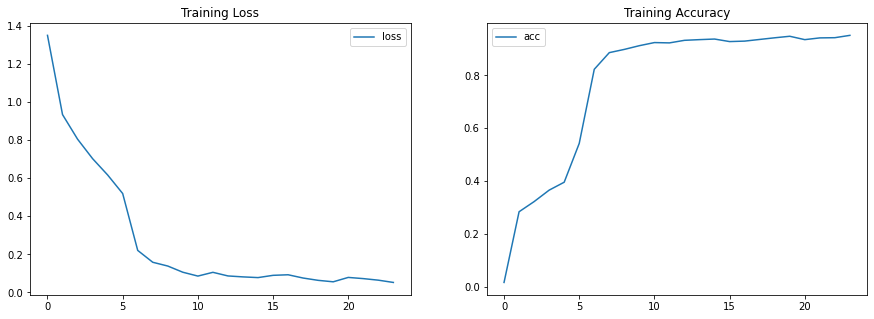

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
# plot some data
ax1.plot(losses, label='loss')
#plt.plot(results.history['val_loss'], label='val_loss')
ax1.set_title('Training Loss')
ax1.legend()
# accuracies
ax2.plot(accuracies, label='acc')
#plt.plot(results.history['val_accuracy_fn'], label='val_acc')
ax2.set_title('Training Accuracy')
ax2.legend()
plt.show()

Prediction

In [ ]:
def predict_seq2seq_att(input_text, input_max_len, vocab_to_int, int_to_vocab):
    if input_text is None:
        input_text = input_data[np.random.choice(len(input_data))]
    #print(input_text)
    # Tokenize the input text
    input_seq = []
    for character in list(input_text):
        #print(character)
        input_seq.append(vocab_to_int[character])
        
    #print(input_seq)
    # Pad the sentence
    input_seq = pad_sequences([input_seq], maxlen=input_max_len, padding='post')
    #print(input_seq)
    # Get the encoder initial states
    en_initial_states = encoder.init_states(1)
    # Get the encoder outputs or hidden states
    en_outputs = encoder(tf.constant(input_seq), en_initial_states)
    # Set the decoder input to the sos token
    de_input = tf.constant([[vocab_to_int['<GO>']]])
    # Set the initial hidden states of the decoder to the hidden states of the encoder
    de_state_h, de_state_c = en_outputs[1:]
    
    out_chars = []
    alignments = []

    while True:
        # Get the decoder with attention output
        de_output, de_state_h, de_state_c, alignment = decoder(
            de_input, (de_state_h, de_state_c), en_outputs[0])
        de_input = tf.expand_dims(tf.argmax(de_output, -1), 0)
        # Detokenize the output
        out_chars.append(int_to_vocab[de_input.numpy()[0][0]])
        # Save the aligment matrix
        alignments.append(alignment.numpy())

        if out_chars[-1] == '<EOS>' or len(out_chars) >= 200:
            break
        
    #print(out_chars)
    # Join the output words
    #print(' '.join(out_chars))
    return np.array(alignments), input_text.split(' '), out_chars

In [ ]:
n_predictions=1
test_sents = ['কি অন্যায় করেছিলাম','আমি োমায় ভালো', 'তিনি এইসব ভাষায় রচিত সঙ্গীত পুস্তকাদি পাঠ করতে শু করলেন', 'বিনোদিী তি বার স্বীকার করিল', 'আমার সোনা বাংলা', '২ ঘণ্টা ্যাঙ্ক খোলা থাকেব যােত মানুষ তাদের ণমভাইনেপ়ত্ নিতে পারব']



for i, test_sent in enumerate(test_sents):
    # Call the predict function to get the translation
    alignments, source, prediction = predict_seq2seq_att(test_sent, input_max_len, vocab_to_int, int_to_vocab)
    attention = np.squeeze(alignments, (1, 2))
    print("".join(prediction))
    

কি অন্যায় করেছিলাম৷<EOS>


KeyError: ignored

Competition test Set

In [ ]:
def isPunc(ch):
    for c in ["।", ",", "?","!",".",";","ঃ","-",'"',"'"]:
        if c == ch:
            return True
    return False



def levenshteinDistanceDP(token1, token2):
    distances = np.zeros((len(token1) + 1, len(token2) + 1))

    for t1 in range(len(token1) + 1):
        distances[t1][0] = t1

    for t2 in range(len(token2) + 1):
        distances[0][t2] = t2
        
    a = 0
    b = 0
    c = 0
    
    for t1 in range(1, len(token1) + 1):
        for t2 in range(1, len(token2) + 1):
            a = distances[t1][t2 - 1]
            b = distances[t1 - 1][t2]
            c = distances[t1 - 1][t2 - 1]
            if (token1[t1-1] == token2[t2-1]):
                distances[t1][t2] = min(a+1,b+1,c)
            else:
                distances[t1][t2] = min(a+1,b+1,c+1)

    i = len(token1)
    j = len(token2)
    str = ""
    while i!=0 and j!=0:
        t = min(distances[i-1][j-1],distances[i][j-1],distances[i-1][j])
        if t == distances[i-1][j-1]:
            if token1[i-1] == token2[j-1]:
                str += token1[i-1]
            else:
                if isPunc(token1[i-1]):
                    str += 'r'
                else:
                    str += 's'
            i = i-1
            j = j-1
        elif t == distances[i][j-1]:
            if isPunc(token2[j-1]):
                str += 'p'
            else:
                
                if token2[j-1] == ' ':
                    str += 'x'
                else:
                    str += 'i'
            j = j-1
        else:
            if isPunc(token1[i-1]):
                str += 'q'
            else:
                
                if token1[i-1] == ' ':
                    str += 'y'
                else:
                    str += 'd'
            i = i-1
    
    if i==0 :
        while j!=0:
            if isPunc(token2[j-1]):
                str += 'p'
            else:
                
                if token2[j-1] == ' ':
                    str += 'x'
                else:
                    str += 'i'
            j = j-1
    
    if j==0 :
        while i!=0:
            if isPunc(token1[i-1]):
                str += 'q'
            else:
                
                if token1[i-1] == ' ':
                    str += 'y'
                else:
                    str += 'd'
            i = i-1

    str = str[::-1]      
    strList2 = str.split()
    strList = []
    
    for li in strList2:
        fi = False
        ci = 0
        ii = 0
        for ch in li:
            if ch == 'i' or ch == 'p' or ch == 's' or ch == 'r':
                ci += 1
                fi = True
            elif ch == 'x' :
                if fi:
                    strList.append(li[ii:ii+ci])
                    ii += (ci +1)
                    fi = False
                    ci = 0
                else:
                    li = li[ii:]
                    break
            else:
                li = li[ii:]
                break
            

        fd = False
        cd = 0
        ii = 0
        for ch in li:
            if ch == 'd' or ch == 'q' or ch == 's' or ch == 'r':
                cd += 1
                fd = True
            elif ch == 'y':
                if fd:
                    strList.append(li[ii:ii+cd])
                    ii += (cd +1)
                    fd = False
                    cd = 0
                else:
                    li = li[ii:]
                    break
            else:
                li = li[ii:]
                break
        ii = 0
        pl = []
        for ch in li:
            if isPunc(ch) or ch == 'p' or ch == 'q' or ch == 'r':
                pl.append(ii)
            ii = ii + 1
        
        if len(pl) == 0:
            if len(li)>0:
                strList.append(li)
        else:
            ii = 0
            co = 0
            for pi in pl:
                co = co +1
                if co == len(pl):
                    if pi == len(li) -1:
                        strList.append(li[ii:])
                    else:
                        strList.append(li[ii:pi+1])
                        strList.append(li[pi+1:])
                elif isPunc(li[pi+1]) or li[pi+1] == 'p' or li[pi+1] == 'q' or li[pi+1] == 'r':
                   
                    continue
                else:
                    strList.append(li[ii:pi+1])
                    ii = pi+1
                

    i = 0
    fstr = ""
    #print(strList2)
    #print(strList)
    for st in strList:
        s1 = ""
        t = len(st)
        dc =0
        ic =0
        sc =0
        pic = 0
        pdc = 0
        psc = 0
        sic = 0
        sdc = 0
        pc = 0
        
        for ch in st:
            if ch == 'd':
                dc +=1
            if ch == 'i' :
                ic +=1
            if ch == 's':
                sc +=1
            if ch == 'p':
                pic +=1
            if ch == 'q':
                pdc +=1
            if ch == 'x':
                sic +=1
            if ch == 'y':
                sdc +=1
            if ch == 'r':
                psc +=1
            if isPunc(ch):
                pc+=1

        tc = ic+sc+dc+sic+sdc+pic+pdc+psc
        
        if tc>0:
            if len(st) == (ic+pic+sic):
                if fstr == "":
                    fstr += ("$$")
                else:
                    fstr += (" $$")
            elif len(st) == (dc+pdc+sdc):
                for it in range(t):
                    s1 += token1[i]
                    i = i+1

                i = i+1

                if fstr == "":
                    fstr += ("$"+s1+"$")
                else:
                    fstr += (" $"+s1+"$")
            else:
                for it in range(t-ic-pic-sic):
                    s1 += token1[i]
                    i = i+1

                i = i+1
                s2 = s1.lstrip()
                if len(s1)> len(s2):
                   
                    if len(s1) - len(s2) == tc:
                        if fstr == "":
                            fstr += ("$"+(' '*(len(s1)-len(s2)))+"$"+s2)
                        else:
                            fstr += (" $"+(' '*(len(s1)-len(s2)))+"$"+s2)
                        
                    else:
                        if fstr == "":
                            fstr += ("$"+(' '*(len(s1)-len(s2)))+"$")
                        else:
                            fstr += (" $"+(' '*(len(s1)-len(s2)))+"$")
                        
                        tc2 = tc - (len(s1) - len(s2))
                        if (pc+pic+psc+pdc) == 0:
                            fstr += ("$"+s2+"$")
                        else:
                            if tc2 == 1 and st[len(st)-1] == 'p':
                                fstr += (s2+"$$")
                            elif tc2 == 1 and isPunc(s2[len(s2)-1]) and (st[len(st)-1] == 'q' or st[len(st)-1] == 'r'):
                                fstr += (s2[0:-1]+"$"+s2[len(s2)-1]+"$")
                            else:
                                pi = -1
                                ci = 0
                                lsi = -1
                                for cii in s2:
                                    if cii == ' ' or cii == 'y':
                                        lsi = ci
                                    if isPunc(cii) or cii =='p' or cii =='q' or cii =='r':
                                        pi = ci
                                        break
                                    ci = ci + 1
                                if tc2 == (pic+psc+pdc):
                                    fstr += (s2[0:pi]+"$"+s2[pi:]+"$")
                                else:
                                    if lsi != pi-1:
                                        if (pic+psc+pdc) == 0:
                                            fstr += ("$"+s2[0:pi]+"$"+s2[pi:])
                                        else:
                                            fstr += ("$"+s2[0:pi]+"$$"+s2[pi:]+"$")
                                    else:
                                        while s2[lsi] == ' ':
                                            lsi = lsi -1
                                            if lsi == -1:
                                                break
                                        lsi = lsi + 1
                                        if (pic+pdc+psc) == 0:
                                            if tc2 == (pi-lsi):
                                                fstr += (s2[0:lsi]+"$"+s2[lsi:pi]+"$"+s2[pi:])
                                                     
                                            else:
                                                fstr += ("$"+s2[0:lsi]+"$$"+s2[lsi:pi]+"$"+s2[pi:])
                                        else:
                                            if tc2 == ((pi-lsi)+pic+pdc+psc):
                                                fstr += (s2[0:lsi]+"$"+s2[lsi:pi]+"$$"+s2[pi:]+"$")
                                                
                                            else:
                                                fstr += ("$"+s2[0:lsi]+"$$"+s2[lsi:pi]+"$$"+s2[pi:]+"$")

                                
                else:
                   
                    tc2 = tc - (len(s1) - len(s2))
                    if (pc+pic+psc+pdc) == 0:
                        if fstr == "":
                            fstr += ("$"+s2+"$")
                        else:
                            fstr += (" $"+s2+"$")
                        
                    else:
                        if tc2 == 1 and st[len(st)-1] == 'p':
                            if fstr == "":
                                fstr += (s2+"$$")
                            else:
                                fstr += (" "+s2+"$$")
                            
                        elif tc2 == 1 and isPunc(s2[len(s2)-1]) and (st[len(st)-1] == 'q' or st[len(st)-1] == 'r'):
                            if fstr == "":
                                fstr += (s2[0:-1]+"$"+s2[len(s2)-1]+"$")
                            else:
                                fstr += (" "+s2[0:-1]+"$"+s2[len(s2)-1]+"$")
                            
                        else:
                            pi = len(s2)-1
                            ci = 0
                            lsi = -1
                            for cii in s2:
                                if cii == ' ' or cii == 'y':
                                    lsi = ci
                                if isPunc(cii) or cii =='p' or cii =='q' or cii =='r':
                                    pi = ci
                                    break
                                ci = ci + 1
                            if tc2 == (pic+psc+pdc):
                                
                                if fstr == "":
                                    fstr += (s2[0:pi]+"$"+s2[pi:]+"$")
                                else:
                                    fstr += (" "+s2[0:pi]+"$"+s2[pi:]+"$")
                                
                            else:
                                if lsi != pi-1:
                                    if (pic+psc+pdc) == 0:
                                        if fstr == "":
                                            fstr += ("$"+s2[0:pi]+"$"+s2[pi:])
                                        else:
                                            fstr += (" $"+s2[0:pi]+"$"+s2[pi:])
                                        
                                    else:
                                        if fstr == "":
                                            fstr += ("$"+s2[0:pi]+"$$"+s2[pi:]+"$")
                                        else:
                                            fstr += (" $"+s2[0:pi]+"$$"+s2[pi:]+"$")
                                        
                                else:
                                    while s2[lsi] == ' ':
                                        lsi = lsi -1
                                        if lsi == -1:
                                            break
                                    lsi = lsi + 1
                                    if (pic+pdc+psc) == 0:
                                        if tc2 == (pi-lsi):
                                            if fstr == "":
                                                fstr += (s2[0:lsi]+"$"+s2[lsi:pi]+"$"+s2[pi:])
                                            else:
                                                fstr += (" "+s2[0:lsi]+"$"+s2[lsi:pi]+"$"+s2[pi:])
                                            
                                        else:
                                            if fstr == "":
                                                fstr += ("$"+s2[0:lsi]+"$$"+s2[lsi:pi]+"$"+s2[pi:])
                                            else:
                                                fstr += (" $"+s2[0:lsi]+"$$"+s2[lsi:pi]+"$"+s2[pi:])
                                    else:
                                        if tc2 == ((pi-lsi)+pic+pdc+psc):
                                            if fstr == "":
                                                fstr += (s2[0:lsi]+"$"+s2[lsi:pi]+"$$"+s2[pi:]+"$")
                                            else:
                                                fstr += (" "+s2[0:lsi]+"$"+s2[lsi:pi]+"$$"+s2[pi:]+"$")
                                            
                                        else:
                                            if fstr == "":
                                                fstr += ("$"+s2[0:lsi]+"$$"+s2[lsi:pi]+"$$"+s2[pi:]+"$")
                                            else:
                                                fstr += (" $"+s2[0:lsi]+"$$"+s2[lsi:pi]+"$$"+s2[pi:]+"$")
                                        
        else:
            for it in range(t):
                s1 += token1[i]
                i = i+1

            i = i+1
            if fstr == "":
                fstr += (s1)
            else:
                fstr += (" "+s1)
    return fstr

def compare(str1, str2):
    try:
        #print(levenshteinDistanceDP(str1, str2))
        return levenshteinDistanceDP(str1, str2)
    except:
        #print(str1)
        return str1
              

compare("আমী ভাত খাই।","আমি ভাত খাই।")
compare("অনেক বাতাষ হচ্ছে।","অনেক বাতাস হচ্ছে।")
compare("আপনি কি আমাকে দেখেছেন।","আপনি কি আমাকে দেখেছেন?")
compare("আপনি কি রিক অ্যান্ড মর্টি দেখেছেন","আপনি কি রিক অ্যান্ড মর্টি দেখেছেন?")
compare("ভাললাগছে ক্লাসকরতে।","ভাল লাগছে ক্লাস করতে।")
compare("তুমি ভাত খাও ।","তুমি ভাত খাও।")
compare("এটা কখনোই আমার পরিকল্পনা ছিল না।","এটা কখনই আমার পরিকল্পনা ছিল না।")
compare("বাংলা ধেষ আমার জন্মভূমি।","বাংলাদেশ আমার জন্মভূমি।")
compare("সে আমি তুমি স্কুলে যাই।","সে, আমি ও তুমি স্কুলে যাই।")
compare("আমি ও স্কুলে যাই।","আমি স্কুলে যাই।")
compare("সে,আমি,তুমি স্কুলে যাই।।।","সে, আমি, তুমি স্কুলে যাই।")#
compare("অন্য   কোন মহিলা এক দূরত্বের মধ্যে পরপর আটটি বিশ্ব রেকর্ড স্থাপন করতে পারেননি।","অন্য কোনো মহিলা এক দূরত্বের মধ্যে পরপর আটটি বিশ্ব রেকর্ড স্থাপন করতে পারেননি।")

'অন্য $  $$কোন$ মহিলা এক দূরত্বের মধ্যে পরপর আটটি বিশ্ব রেকর্ড স্থাপন করতে পারেননি।'

In [ ]:
file_path  = "/content/drive/MyDrive/Colab_Notebooks/test.csv"
data = pd.read_csv(file_path)
test_sentences = data['text']
print(test_sentences[1])

ইউনিটগণ, পিছিয়ে যান।


In [ ]:
test_prediction =[]
test_correct = []
for i, test_sent in enumerate(test_sentences):
    # Call the predict function to get the translation
    test_sentence = clean_sentence(test_sent)
    alignments, source, prediction = predict_seq2seq_att(test_sentence, input_max_len, vocab_to_int, int_to_vocab)
    attention = np.squeeze(alignments, (1, 2))
    result = "".join(prediction)
    result  = re.sub(r'<EOS>', '', result)
    test_correct.append(result)
    test_prediction.append(compare(test_sent, result))
    print(test_sent, result, compare(test_sent, result))

ব্যক্তি থেকেই শুরু যার সমাপ্তি হবে বিশ্বে মুসলিমদের মহত্ত্বের চর্চায় যেমনটি আগে ছিল রাসূলের আদর্শে আছে। ব্যক্তি থেকেই শুরু যার সমাপ্তি হবে বিশ্বে মুসলিমদের মহত্ত্বের চর্চায় যেমনটি আগে ছিল রাসূলের আদর্শে আছে৷ ব্যক্তি থেকেই শুরু যার সমাপ্তি হবে বিশ্বে মুসলিমদের মহত্ত্বের $চর্চায়$ যেমনটি আগে ছিল রাসূলের আদর্শে আছে$।$
ইউনিটগণ, পিছিয়ে যান। ইউনিটগণ, পিছিয়ে যান৷ ইউনিটগণ, $পিছিয়ে$ যান$।$
ভিক্টোরিয়ার ক্লেটন ক্যাম্পাসে ছয়টি আবাসিক হল রয়েছে। ভিক্টোরিয়ার ক্লেটন ক্যাম্পাসে ছয়টি আবাসিক হল রয়েছে৷ $ভিক্টোরিয়ার$ ক্লেটন ক্যাম্পাসে ছয়টি আবাসিক হল রয়েছে$।$
তেমনি আবির একটা বইপোঁকা সেটা বললে ভুল হবেনা। তেমনি আবির একটা বইপোঁকা সেটা বললে ভুল হবেনা৷ তেমনি আবির একটা $বইপোঁকা$ সেটা বললে ভুল হবেনা$।$
আমরা চাই গরিব চাচা যেন তারনেয্য টাকা পিরে পায় এবং সারা বাংলাদেসে যমুনা টিবির সুনাম বয়ে জায় আমরা চাই গরিব চাচা যেন তারনেয্য টাকা পিরে পায় এবং সারা বাংলাদেশে যুমনা টিবির সুনাম বয়ে জায়৷ আমরা চাই গরিব চাচা যেন তারনেয্য টাকা পিরে $পায়$ এবং সারা $বাংলাদেসে$ $যমুনা$ টিবির সুনাম $বয়ে$ $জায়$
আমি একজন আদনান ভাই

KeyboardInterrupt: ignored

In [ ]:
data = pd.DataFrame(test_sentences[:1617])
print(data)
data['correct'] = test_correct
data['error'] = test_prediction
data.to_csv('/content/predictions.csv')


                                                   text
0     ব্যক্তি থেকেই শুরু যার সমাপ্তি হবে বিশ্বে মুসল...
1                                  ইউনিটগণ, পিছিয়ে যান।
2     ভিক্টোরিয়ার ক্লেটন ক্যাম্পাসে ছয়টি আবাসিক হল...
3          তেমনি আবির একটা বইপোঁকা সেটা বললে ভুল হবেনা।
4     আমরা চাই গরিব চাচা যেন তারনেয্য টাকা পিরে পায় ...
...                                                 ...
1612  আমি নিচ থেকেই একটা থাম্বস আপ,  দেখিয়ে ফ্লাইং ক...
1613  কিন্তু পেত্রার অবস্থা দেখে মৃদু হেসে ইশারায় সা...
1614           সে একাই থাকে তার ছোট ছেলেকে নিয়ে শেরপুর।
1615                  আমাদের যা করার ছিল আমি তাই করেছি।
1616  আমি তোকে অনেক ভালোবাসি কিন্তু হয়তো কখনোই এটা ত...

[1617 rows x 1 columns]
